In [33]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial 

import scipy.integrate as integrate
import scipy.special as special

In [34]:
# Import data
SP = pd.read_excel("data/SP500_2020.xlsx") # spot price
SPF = pd.read_excel("data/SP500FUT_2020.xlsx") # future price

In [35]:
# train-test split
train_SP = SP.iloc[1000:1500, :]
train_SPF = SPF.iloc[1000:1500, :]

test_SP = SP.iloc[1500:2000, :]
test_SPF = SPF.iloc[1500:2000, :]

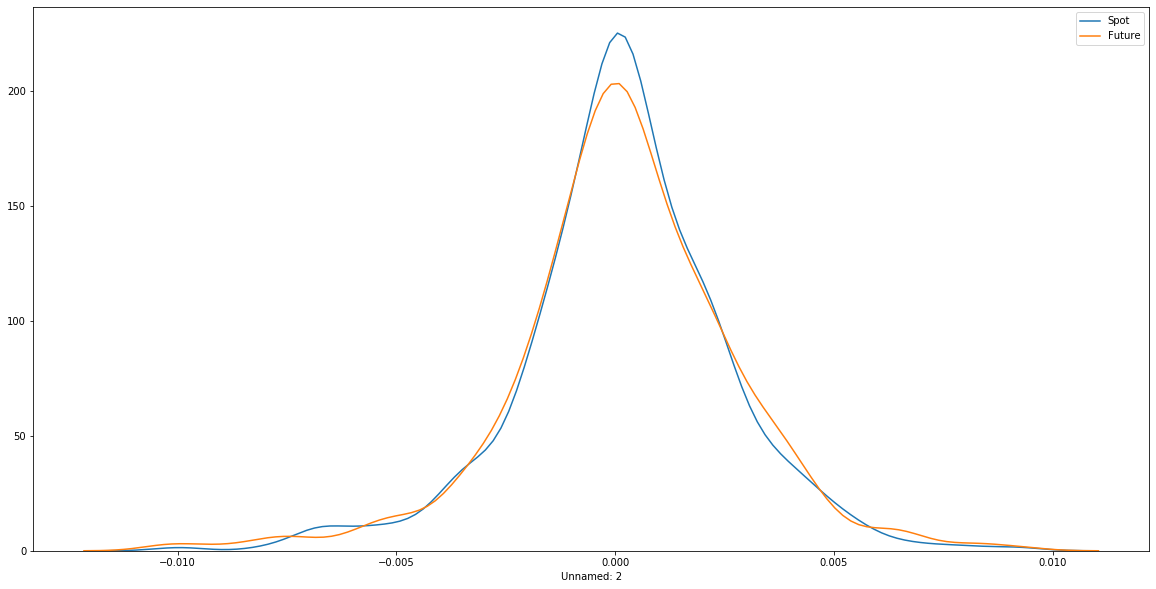

In [36]:
plt.figure(figsize=(20,10))
sns.distplot(train_SP.iloc[:,2], hist=False, label='Spot')
sns.distplot(train_SPF.iloc[:,2], hist=False, label='Future')
plt.legend()

In [180]:
def hedge_portfolio(spot, future, h):
    return spot - (h*future)

In [181]:
h=.75
train_H = hedge_portfolio(train_SP.iloc[:,2],train_SPF.iloc[:,2], h)
test_H = hedge_portfolio(test_SP.iloc[:,2],test_SPF.iloc[:,2], h)

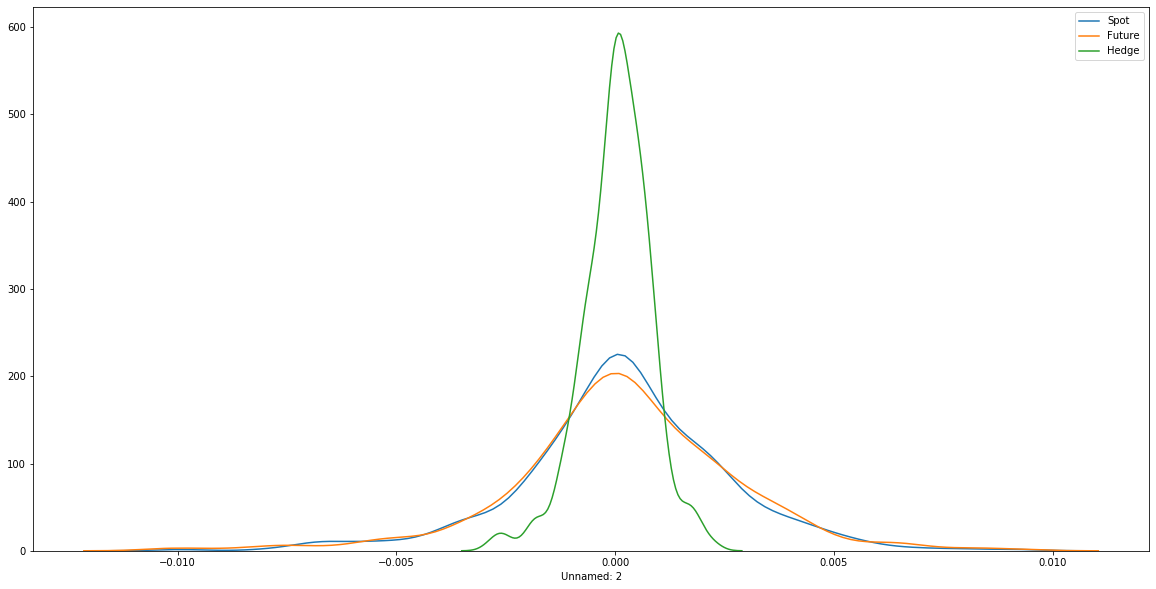

In [182]:
plt.figure(figsize=(20,10))
sns.distplot(train_SP.iloc[:,2], hist=False, label='Spot')
sns.distplot(train_SPF.iloc[:,2], hist=False, label='Future')
sns.distplot(train_H, hist=False, label='Hedge')
plt.legend()

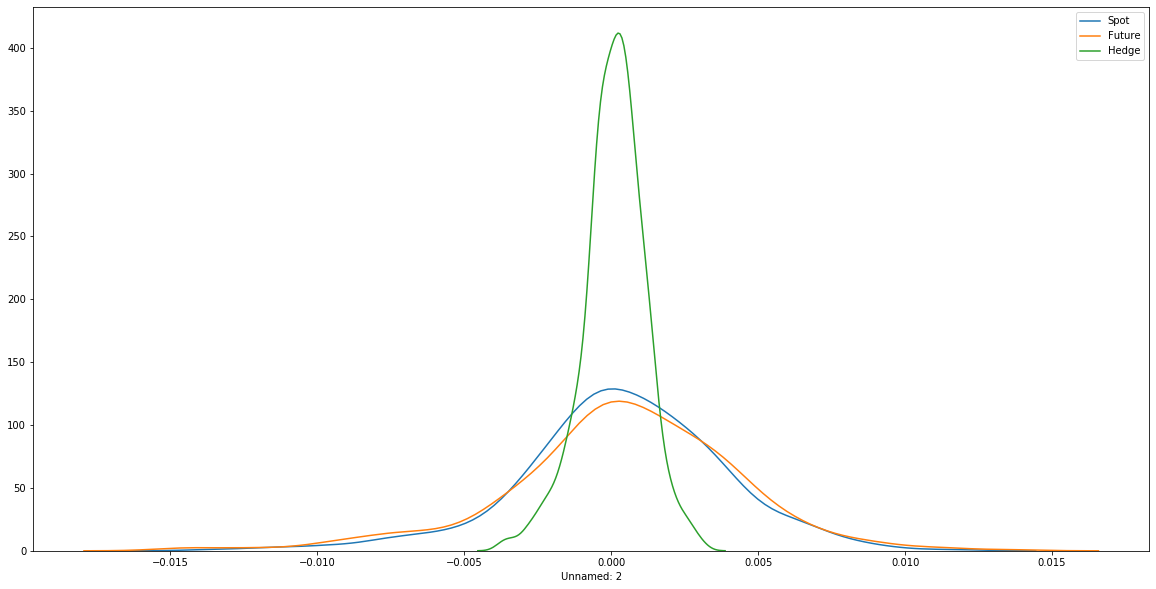

In [183]:

plt.figure(figsize=(20,10))
sns.distplot(test_SP.iloc[:,2], hist=False, label='Spot')
sns.distplot(test_SPF.iloc[:,2], hist=False, label='Future')
sns.distplot(test_H, hist=False, label='Hedge')
plt.legend()

In [184]:
def ERM(k, r):
    # k: the risk aversiveness
    # r: return of a hedged portfolio or any assets
    def integrand(k, r, s):
        w = k*np.exp(-k*s)/(1-np.exp(-k))
        q = np.quantile(r, s)
        return w*q
    
    integrand_to_integrate = partial(integrand, k, r)

    risk_measure = - integrate.quad(integrand_to_integrate , 0,1)[0]
    
    return risk_measure

In [240]:
n1 = 30
n2 = 10
hs = np.linspace(0,2, n1)
ks = np.logspace(-1, 1.5, n2, endpoint=True)

train_erm = np.zeros((n1, n2))
test_erm = np.zeros((n1, n2))

for i, h in enumerate(hs):
    train_H = hedge_portfolio(train_SP.iloc[:,2],train_SPF.iloc[:,2], h)
    test_H = hedge_portfolio(test_SP.iloc[:,2],test_SPF.iloc[:,2], h)
    for j, k in enumerate(ks):
        train_erm[i, j] = ERM(k, train_H)
        test_erm[i, j] = ERM(k, test_H)

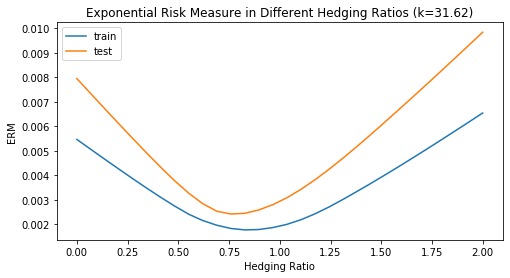

In [248]:
m = -1
k = ks[m]
plt.figure(figsize=(8,4))
plt.title("Exponential Risk Measure in Different Hedging Ratios (k=%.2f)" %round(k, 2))
plt.plot(hs, train_erm[:,m], label='train')
plt.plot(hs, test_erm[:,m], label='test')
plt.ylabel('ERM')
plt.xlabel('Hedging Ratio')
plt.legend()

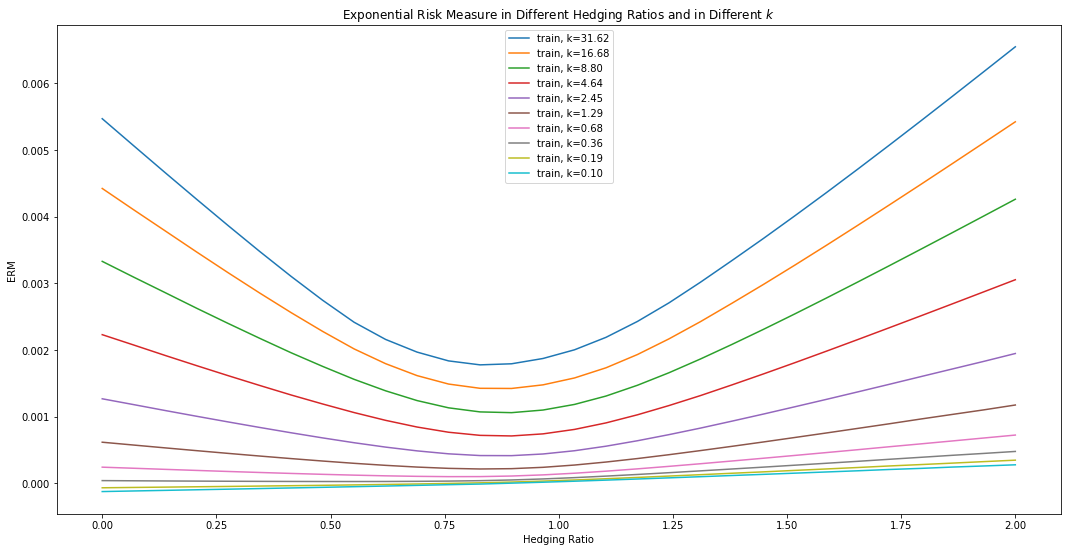

In [278]:
plt.figure(figsize=(18,9))
plt.title("Exponential Risk Measure in Different Hedging Ratios and in Different $k$")

l = reversed(range(len(ks)))
for m in l:
    k = ks[m]
    plt.plot(hs, train_erm[:,m], label="train, k=%.2f" %round(k, 2))
    # plt.plot(hs, test_erm[:,m], label="test, k=%.2f" %round(k, 2), color='g', linestyle='-.')
    plt.ylabel('ERM')
    plt.xlabel('Hedging Ratio')


plt.legend()

In [242]:
OHR_position_train = np.argmin(train_erm, axis=0)
OHR_train = hs[OHR_position_train]

OHR_position_test = np.argmin(test_erm, axis=0)
OHR_test = hs[OHR_position_test]

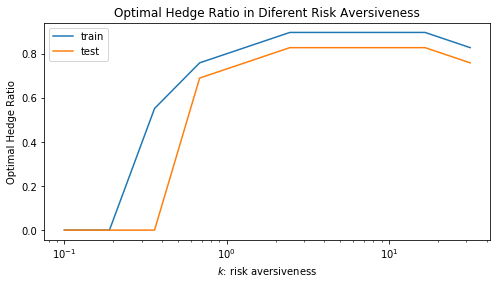

In [243]:
plt.figure(figsize=(8,4))
plt.title("Optimal Hedge Ratio in Diferent Risk Aversiveness")
plt.plot(ks, OHR_train, label='train')
plt.plot(ks, OHR_test, label='test')

plt.xlabel("$k$: risk aversiveness")
plt.xscale('log')
plt.ylabel("Optimal Hedge Ratio")
plt.legend()

In [244]:
from scipy.interpolate import interp1d

In [246]:
f = interp1d(hs, train_erm[:,9], kind='cubic' )
xnew = np.linspace(hs[0], hs[-1], num=1000, endpoint=True)
min(f(xnew))

0.0017736447589978815

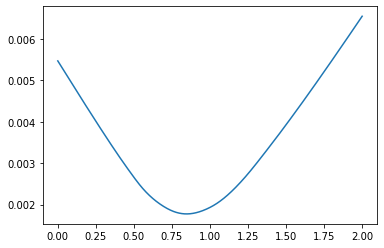

In [247]:
plt.plot(xnew, f(xnew))